<a href="https://colab.research.google.com/github/AdrianaCott14/CS_472/blob/main/Adri_Cottle_lab_3_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree Lab

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
import pandas as pd

## 1. (40%) Correctly implement the ID3 decision tree algorithm, including the ability to handle unknown attributes (You do not need to handle real valued attributes).  
### Code Requirements/Notes:
- Use standard information gain as your basic attribute evaluation metric.  (Note that normal ID3 would usually augment information gain with gain ratio or some other mechanism to penalize statistically insignificant attribute splits.) 
- You are welcome to create other classes and/or functions in addition to the ones provided below. (e.g. If you build out a tree structure, you might create a node class).
- It is a good idea to use a simple data set (like the lenses data or the pizza homework), which you can check by hand, to test your algorithm to make sure that it is working correctly. 

In [ ]:
def log_base2(x):
  return np.log2(x) if x != 0 else 0

In [ ]:
class DTNode():
  def __init__(self, sp_val):
    self.children = []
    self.return_val = None
    self.split_index = None
    self.split_val = None

  def ID3(self, X, y, counts, info_gains):
    #note let's start with the base case
    
    #if all y's are the same, then just set self.return_val to that y
    if len(np.unique(y)) == 1:
      self.return_val = y[0][0]
      return

    #if there are no more features to split on, then just set self.return_val to majority y
    if len(X[0]) == 0:
      vals, counts = np.unique(y, return_counts = True)
      ind = np.argmax(counts)
      self.return_val = vals[ind]
      return

    #if I don't get caught in the base cases, then let's do the ID3
    #first find the feature from X/y that you should split on
    entropy = self._calc_entropy(y, counts[-1])

    entropy_features = self._calc_feature_entropies(X, y, counts)

    minI = -1
    minE = float('inf')
    for i in range(len(entropy_features)):
      if entropy_features[i] < minE:
        minI = i
        minE = entropy_features[i]

    info_gains.append(entropy - minE)
    self.split_index = minI
    
    #then once you know which feature to split on, seperate up X and y into the respective sets of data

    X_col = X[:, minI]
    split_feature_classes = np.unique(X_col)
    for i in range(len(split_feature_classes)):
      mask = X_col == split_feature_classes[i]

      #make new Node objects for the branches that we're going make, add those to list of children
      child = DTNode(split_feature_classes[i])

      #for each of those children call this .ID3 method with the respective sets of data
      child.ID3(np.delete(X[mask], minI, 1), y[mask], np.delete(counts, minI), info_gains)

      #good idea to keep track of which feature it is you split on and which child corresponds for which value of that feature
      child.split_val = split_feature_classes[i]
      self.children.append(child)
    # print(split_feature_classes)
    # print(child.split_val)
   

  def _calc_entropy(self, y, num_classes):
      classes = np.unique(y, axis = 0)
      sum = 0
      for i in range(num_classes):
        if i >= len(classes):
          continue
        mask = y == classes[i][0]
        fr = (len(y[mask]) / len(y))
        sum += fr * log_base2(fr)

      return -1 * sum
  
  def _calc_feature_entropies(self, X, y, feature_counts):
    info_gain = []
    for i in range(len(X[0])):
      X_col = X[:, i]
      classes = np.unique(X_col)
      sum = 0
      for cl in classes:
        mask = X_col == cl
        fr = len(X_col[mask]) / len(X)
        parenth = self._calc_entropy(y[mask], feature_counts[-1])
        sum += fr * parenth
      info_gain.append(sum)
    return info_gain

  def predict(self, to_pred):
    #if I am a node that is at the end of a branch, then self.return_val != None, and just return that
    #otherwise, on the feature that I split on, one of my children corresponds to the value that is in to_pred
    #so ask that child what the prediction of to_pred is.
    if self.return_val is not None:
      return self.return_val

    for child in self.children:
      if child.split_val == to_pred[self.split_index]:
        return child.predict(np.delete(to_pred, self.split_index))
    

In [ ]:
class DTClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self):
        """ Initialize class with chosen hyperparameters.
        Args:
        Optional Args (Args we think will make your life easier):
            counts: A list of Ints that tell you how many types of each feature there are
        Example:
            DT  = DTClassifier()
            or
            DT = DTClassifier(count = [2,3,2,2])
            Dataset = 
            [[0,1,0,0],
            [1,2,1,1],
            [0,1,1,0],
            [1,2,0,1],
            [0,0,1,1]]

        """

    def fit(self, X, y, counts):
        """ Fit the data; Make the Decision tree

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 1D numpy array with the training targets

        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """
        self.info_gains = []
        self.rootNode = DTNode(None)
        self.rootNode.ID3(X, y, np.array(counts), self.info_gains)
        return self

    def predict(self, X):
        """ Predict all classes for a dataset X

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets

        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        predictions = []
        for row in X:
          predictions.append([self.rootNode.predict(row)])

        return np.array(predictions)


    def score(self, X, y):
        """ Return accuracy(Classification Acc) of model on a given dataset. Must implement own score function.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 1D numpy array of the targets 
        """
        return (self.predict(X) == y).mean()



## 1.1 Debug

Debug your model by training on the lenses dataset: [Debug Dataset (lenses.arff)](https://byu.instructure.com/courses/14142/files?preview=4622251)

Test your model on the lenses test set: [Debug Test Dataset (lenses_test.arff)](https://byu.instructure.com/courses/14142/files?preview=4622254)

Parameters:
(optional) counts = [3,2,2,2] (You should compute this when you read in the data, before fitting)

---

Expected Results: Accuracy = [0.33]

Predictions should match this file: [Lenses Predictions (pred_lenses.csv)](https://byu.instructure.com/courses/14142/files?preview=4622260)

*NOTE: The [Lenses Prediction (pred_lenses.csv)](https://byu.instructure.com/courses/14142/files?preview=4622260) uses the following encoding: soft=2, hard=0, none=1. If your encoding is different, then your output will be different, but not necessarily incorrect.*

Split Information Gains (These do not need to be in this exact order):

[0.5487949406953987, 0.7704260414863775, 0.3166890883150208, 1.0, 0.4591479170272447, 0.9182958340544894]

<!-- You should be able to get about 68% (61%-82%) predictive accuracy on the lenses data -->

Here's what your decision tree splits should look like, and the corresponding child node predictions:

Decision Tree:
<pre>
tear_prod_rate = normal:
    astigmatism = no:
        age = pre_presbyopic:
            prediction: soft
        age = presbyopic:
            spectacle_prescrip = hypermetrope:
                prediction: soft
            spectacle_prescrip = myope:
                prediction: none
        age = young:
            prediction: soft
    astigmatism = yes:
        spectacle_prescrip = hypermetrope:
            age = pre_presbyopic:
                prediction: none
            age = presbyopic:
                prediction: none
            age = young:
                prediction: hard
        spectacle_prescrip = myope:
            prediction: hard
tear_prod_rate = reduced:
    prediction: none
</pre>

In [ ]:
# Load debug training data 
data = arff.loadarff('/content/lenses.arff')
df = pd.DataFrame(data[0])
debugNP = np.array(df).astype(str)

debugInputs = debugNP[:, :-1] # X
debugTargets = debugNP[:, -1:] # y
# print(debugInputs)
# print(debugTargets)

# Train Decision Tree
model = DTClassifier()
model.fit(debugInputs, debugTargets, [3, 2, 2, 2, 3])

# Load debug test data
dataTest = arff.loadarff('/content/lenses_test.arff')
dfTest = pd.DataFrame(dataTest[0])
debugNPTest = np.array(dfTest).astype(str)

debugInputsTest = debugNPTest[:, :-1] # X
debugTargetsTest = debugNPTest[:, -1:] # y

# Predict and compute model accuracy
print("Accruracy: ", model.score(debugInputsTest, debugTargetsTest))
# Print the information gain of every split you make.
for info_gain in model.info_gains:
  print(info_gain)



Accruracy:  0.3333333333333333
0.5487949406953982
0.7704260414863778
0.3166890883150208
1.0
0.4591479170272448
0.9182958340544896


In [ ]:
# Optional/Additional Debugging Dataset - Pizza Homework
pizza_dataset = np.array([[1,2,0],[0,0,0],[0,1,1],[1,1,1],[1,0,0],[1,0,1],[0,2,1],[1,0,0],[0,2,0]])
pizza_labels = np.array([[2],[0],[1],[2],[1],[2],[1],[1],[0]])

In [ ]:
pizza_model = DTClassifier()
pizza_model.fit(pizza_dataset, pizza_labels, [2, 3, 2, 3])
new_pizza_data = np.array([[0, 0, 0]])

## 1.2 Evaluation

We will evaluate your model based on its performance on the zoo dataset. 

Train your model using this dataset: [Evaluation Train Dataset (zoo.arff)](https://byu.instructure.com/courses/14142/files?preview=4622270)

Test your model on this dataset: [Evaluation Test Dataset (zoo_test.arff)](https://byu.instructure.com/courses/14142/files?preview=4622274)

Parameters:
(optional) counts = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2] (You should compute this when you read in the data, before fitting)

---
Print out your accuracy on the evaluation test dataset.

Print out the information gain of every split you make.

In [ ]:
# Load evaluation training data
data = arff.loadarff('/content/zoo.arff')
df = pd.DataFrame(data[0])
evalNP = np.array(df).astype(str)

evalInputs = evalNP[:, :-1] # X
evalTargets = evalNP[:, -1:] # y

# Train Decision Tree
model = DTClassifier()
model.fit(evalInputs, evalTargets, [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 7])

# Load evaluation test data
data = arff.loadarff('/content/zoo_test.arff')
df = pd.DataFrame(data[0])
evalNP = np.array(df).astype(str)

evalInputsTest = evalNP[:, :-1] # X
evalTargetsTest = evalNP[:, -1:] # y

# Print out the information gain for every split you make
print("Accruracy: ", model.score(evalInputsTest, evalTargetsTest))
print("info_gains:")
for info_gain in model.info_gains:
  print(info_gain)

Accruracy:  0.147
info_gains:
1.3630469031539394
0.8865408928220899
0.9852281360342515
0.6962122601251459
0.8256265261578954
0.6892019851173656
0.8631205685666308
0.7219280948873623
0.7219280948873623


## 2. (20%) You will use your ID3 algorithm to induce decision trees for the cars dataset and the voting dataset.  Do not use a stopping criterion, but induce the tree as far as it can go (until classes are pure or there are no more data or attributes to split on).  
- Implement and use 10-fold Cross Validation (CV) on each data set to predict how well the models will do on novel data.  
- For each dataset, report the training and test classification accuracy for each fold and the average test accuracy. 
- As a rough sanity check, typical decision tree accuracies for these data sets are: Cars: .90-.95, Vote: .92-.95.

## 2.1 Implement 10-fold Cross Validation

In [ ]:
# Write a function that implements 10-fold cross validation
def cross_validation(X, y, counts, num_folds=10):
  train_accuracies = []
  test_accuracies = []

  # split the data
  split_x = np.array_split(X, num_folds)
  split_y = np.array_split(y, num_folds)

  for i in range(len(split_x)):
    train_x = split_x.copy()
    train_y = split_y.copy()

    # pull out validation data
    val_x = train_x.pop(i)
    val_y = train_y.pop(i)

    train_x = np.concatenate(train_x)
    train_y = np.concatenate(train_y)
    # print(len(test_y), "test y")
    # print(len(val_y), "val y")
    # print(test_y, "test y")
    # print(val_y, "val y")

    model = DTClassifier()
    model.fit(train_x, train_y, counts)

    train_accuracies.append(model.score(train_x, train_y))
    test_accuracies.append(model.score(val_x, val_y))
   
  return train_accuracies, test_accuracies


##  2.2 Cars Dataset
- Use this [Cars Dataset (cars.arff)](https://byu.instructure.com/courses/14142/files?preview=4622293)
- Make a table for your k-fold cross validation accuracies

*If you are having trouble using scipy's loadarff function (scipy.io.arff.loadarff), try:*

*pip install arff &nbsp;&nbsp;&nbsp;&nbsp;          # Install arff library*

*import arff as arf*                   

*cars = list(arf.load('cars.arff'))   &nbsp;&nbsp;&nbsp;&nbsp;# Load your downloaded dataset (!curl, etc.)*

*df = pd.DataFrame(cars)*  

*There may be additional cleaning needed*

In [ ]:
# Use 10-fold CV on Cars Dataset
data = arff.loadarff('/content/cars.arff')
df = pd.DataFrame(data[0])
carsNP = np.array(df).astype(str)

carsInputs = carsNP[:, :-1] # X
carsTargets = carsNP[:, -1:] # y

train_acc, test_acc = cross_validation(carsInputs, carsTargets, [4, 4, 4, 3, 3, 3, 4])

# Report Training and Test Classification Accuracies
df_acc = pd.DataFrame(list(zip(train_acc, test_acc)), columns=['Train', 'Test'])

# Report Average Test Accuracy
np.array(test_acc)
print("Avg Test Accuracy", np.mean(test_acc))
df_acc

Avg Test Accuracy 0.725591477349106


,Train,Test
0,1.0,0.780347
1,1.0,0.710983
2,1.0,0.867052
3,1.0,0.768786
4,1.0,0.699422
5,1.0,0.699422
6,1.0,0.658960
7,1.0,0.797688
8,1.0,0.645349
9,1.0,0.627907


## 2.3 Voting Dataset
- Use this [Voting Dataset with missing values (voting_with_missing.arff)](https://byu.instructure.com/courses/14142/files?preview=4622298)
- Note that you will need to support unknown attributes in the voting data set. 

In [ ]:
# Used 10-fold CV on Voting Dataset
data = arff.loadarff('/content/voting_with_missing.arff')
df = pd.DataFrame(data[0])
votingNP = np.array(df).astype(str)

votingInputs = votingNP[:, :-1] # X
votingTargets = votingNP[:, -1:] # y

train_acc, test_acc = cross_validation(votingInputs, votingTargets, [2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

# Report Training and Test Classification Accuracies
df_acc = pd.DataFrame(list(zip(train_acc, test_acc)), columns=['Train', 'Test'])

# Report Average Test Accuracy
np.array(test_acc)
print("Avg Test Accuracy", np.mean(test_acc))
df_acc

Avg Test Accuracy 0.9376321353065539


,Train,Test
0,1.0,0.977273
1,1.0,0.954545
2,1.0,0.954545
3,1.0,0.954545
4,1.0,0.977273
5,1.0,0.953488
6,1.0,0.930233
7,1.0,0.883721
8,1.0,0.860465
9,1.0,0.930233


## 2.4 Discuss Your Results

- Summarize your results from both datasets, and discuss what you observed. 
- A fully expanded tree will often get 100% accuracy on the training set. Why does this happen and in what cases might it not?  

I noticed that between the cars and voting data, my accuracies were a lot higher for the voting data. The cars data had an average accuracy of about 73% while the voting data was about 94%. 

At first I was a little surprised to see that the training set was returning a 100% accuracy but it made more sense after I thought about it. The decision tree was built off of the training set so it should match that data with 100% accuracy, otherwise I would be worried with how the tree was being expanded. 

## 3. (15%) For each of the two problems above, summarize in English what the decision tree has learned (i.e., look at the induced tree and describe what rules it has discovered to try to solve each task). 
- If the tree is very large you can just discuss a few of the more shallow attribute combinations and the most important decisions made high in the tree.

## 3.1 Discuss what the decision tree induced on the cars dataset has learned

One thing I noticed is that often the leaf nodes would split on either '5more' or 'small'. Those two features were quite common which probably meant the data varied a lot within those features. 

## 3.2 Discuss what the decision tree induced on the voting dataset has learned

When fist looking at the features at each split and the values where the split happened, I see that there were a lot of leaf nodes in this tree. It makes sense because it's a relatively large dataset, but it was something I noticed right off the bat. I also noticed that 'y' was the most frequently common feature to split on. 

## 3.3 How did you handle unknown attributes in the voting problem? Why did you choose this approach? (Do not use the approach of just throwing out data with unknown attributes).

I noticed that within the voting dataset the unknowns were labeled with a '?' and so I just handled that as another feature. So instead of passing in 2 for the number of features (for 'y' and 'n') I added one to those that had missing values, which was all the but the first two attributes. Honestly, the main reason I chose this method was because it was the simplest and less time consuming.

## 4.1 (10%) Use Scikit Learn's decision tree on the voting dataset and compare your results. Try different parameters and report what parameters perform best on the test set. 

### 4.1.1 sklearn on Voting Dataset
- Use this [Voting Dataset with missing values (voting_with_missing.arff)](https://byu.instructure.com/courses/14142/files?preview=4622298)

In [ ]:
# Use sklearn's Decision Tree to learn the voting dataset
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score

for col in df:
  if not pd.api.types.is_numeric_dtype(df[col]):
    df = pd.get_dummies(df, columns=[col], drop_first=True)

votingNP = np.array(df).astype(str)

votingInputs = votingNP[:, :-1] # X
votingTargets = votingNP[:, -1:] # y

# Explore different parameters
clf_basic = DecisionTreeClassifier()
clf_basic = clf_basic.fit(votingInputs, votingTargets)

clf2 = DecisionTreeClassifier(splitter='random', max_depth=10)
clf2 = clf2.fit(votingInputs, votingTargets)

clf3 = DecisionTreeClassifier(random_state=12345, criterion='entropy')
clf3 = clf2.fit(votingInputs, votingTargets)

# Report results
print(cross_val_score(clf_basic, votingInputs, votingTargets, cv=10))
print("Mean: ", np.mean(cross_val_score(clf_basic, votingInputs, votingTargets, cv=10)))
print()
print(cross_val_score(clf2, votingInputs, votingTargets, cv=10))
print("Mean: ", np.mean(cross_val_score(clf2, votingInputs, votingTargets, cv=10)))
print()
print(cross_val_score(clf3, votingInputs, votingTargets, cv=10))
print("Mean: ", np.mean(cross_val_score(clf3, votingInputs, votingTargets, cv=10)))

[0.84328358 0.82089552 0.76865672 0.81343284 0.82089552 0.82089552
 0.79104478 0.78358209 0.7518797  0.78947368]
Mean:  0.7996970037032881

[0.82835821 0.79104478 0.7238806  0.79104478 0.74626866 0.78358209
 0.71641791 0.76119403 0.80451128 0.80451128]
Mean:  0.7727808326787117

[0.79104478 0.78358209 0.73880597 0.80597015 0.8358209  0.79104478
 0.79104478 0.75373134 0.79699248 0.79699248]
Mean:  0.7802771855010662


When comparing the accuracies that my modelreturned vs. those from the sklearn models, they are all around the same numbers. I also noticed that the last model I built, the one with a random state and criterion set to entropy, has the smallest spread of accuracies compared to their other two.

## 4.2 (10%) Choose a data set of your choice (not already used in this or previous labs) and use the sklearn decision tree to learn it. Experiment with different hyper-parameters to try to get the best results possible.

In [ ]:
# Use sklearn's Decision Tree on a new dataset
df = pd.read_csv('https://www.ishelp.info/data/insurance.csv')

y = df.smoker
x = df.drop(columns=['smoker'])

for col in x:
  if not pd.api.types.is_numeric_dtype(df[col]):
    x = pd.get_dummies(x, columns=[col], drop_first=True)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=12345)

clf = DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

# Experiment with different hyper-parameters
clf2 = DecisionTreeClassifier(splitter='random', max_depth=10)
clf2 = clf2.fit(x_train, y_train)

clf3 = DecisionTreeClassifier(random_state=12345, criterion='entropy')
clf3 = clf2.fit(x_train, y_train)

# Report results
print(cross_val_score(clf, x_test, y_test, cv=10))
print("Mean: ", np.mean(cross_val_score(clf, x_test, y_test, cv=10)))
print()
print(cross_val_score(clf2, x_test, y_test, cv=10))
print("Mean: ", np.mean(cross_val_score(clf2, x_test, y_test, cv=10)))
print()
print(cross_val_score(clf3, x_test, y_test, cv=10))
print("Mean: ", np.mean(cross_val_score(clf3, x_test, y_test, cv=10)))

[0.95121951 0.95121951 0.95       1.         0.975      1.
 0.975      0.975      1.         0.95      ]
Mean:  0.9751829268292683

[0.97560976 1.         0.95       0.9        0.975      1.
 0.95       0.925      0.95       0.975     ]
Mean:  0.9551829268292682

[0.87804878 0.92682927 0.95       0.975      0.975      0.95
 0.925      0.9        0.975      0.9       ]
Mean:  0.9528658536585365


## 5. (5%) Visualize sklearn's decision tree for your chosen data set (using export_graphviz or another tool) and discuss what you find. If your tree is too deep to reasonably fit on one page, show only the first few levels (e.g., top 5).

In [ ]:
# !pip install graphviz
# !pip install pydotplus

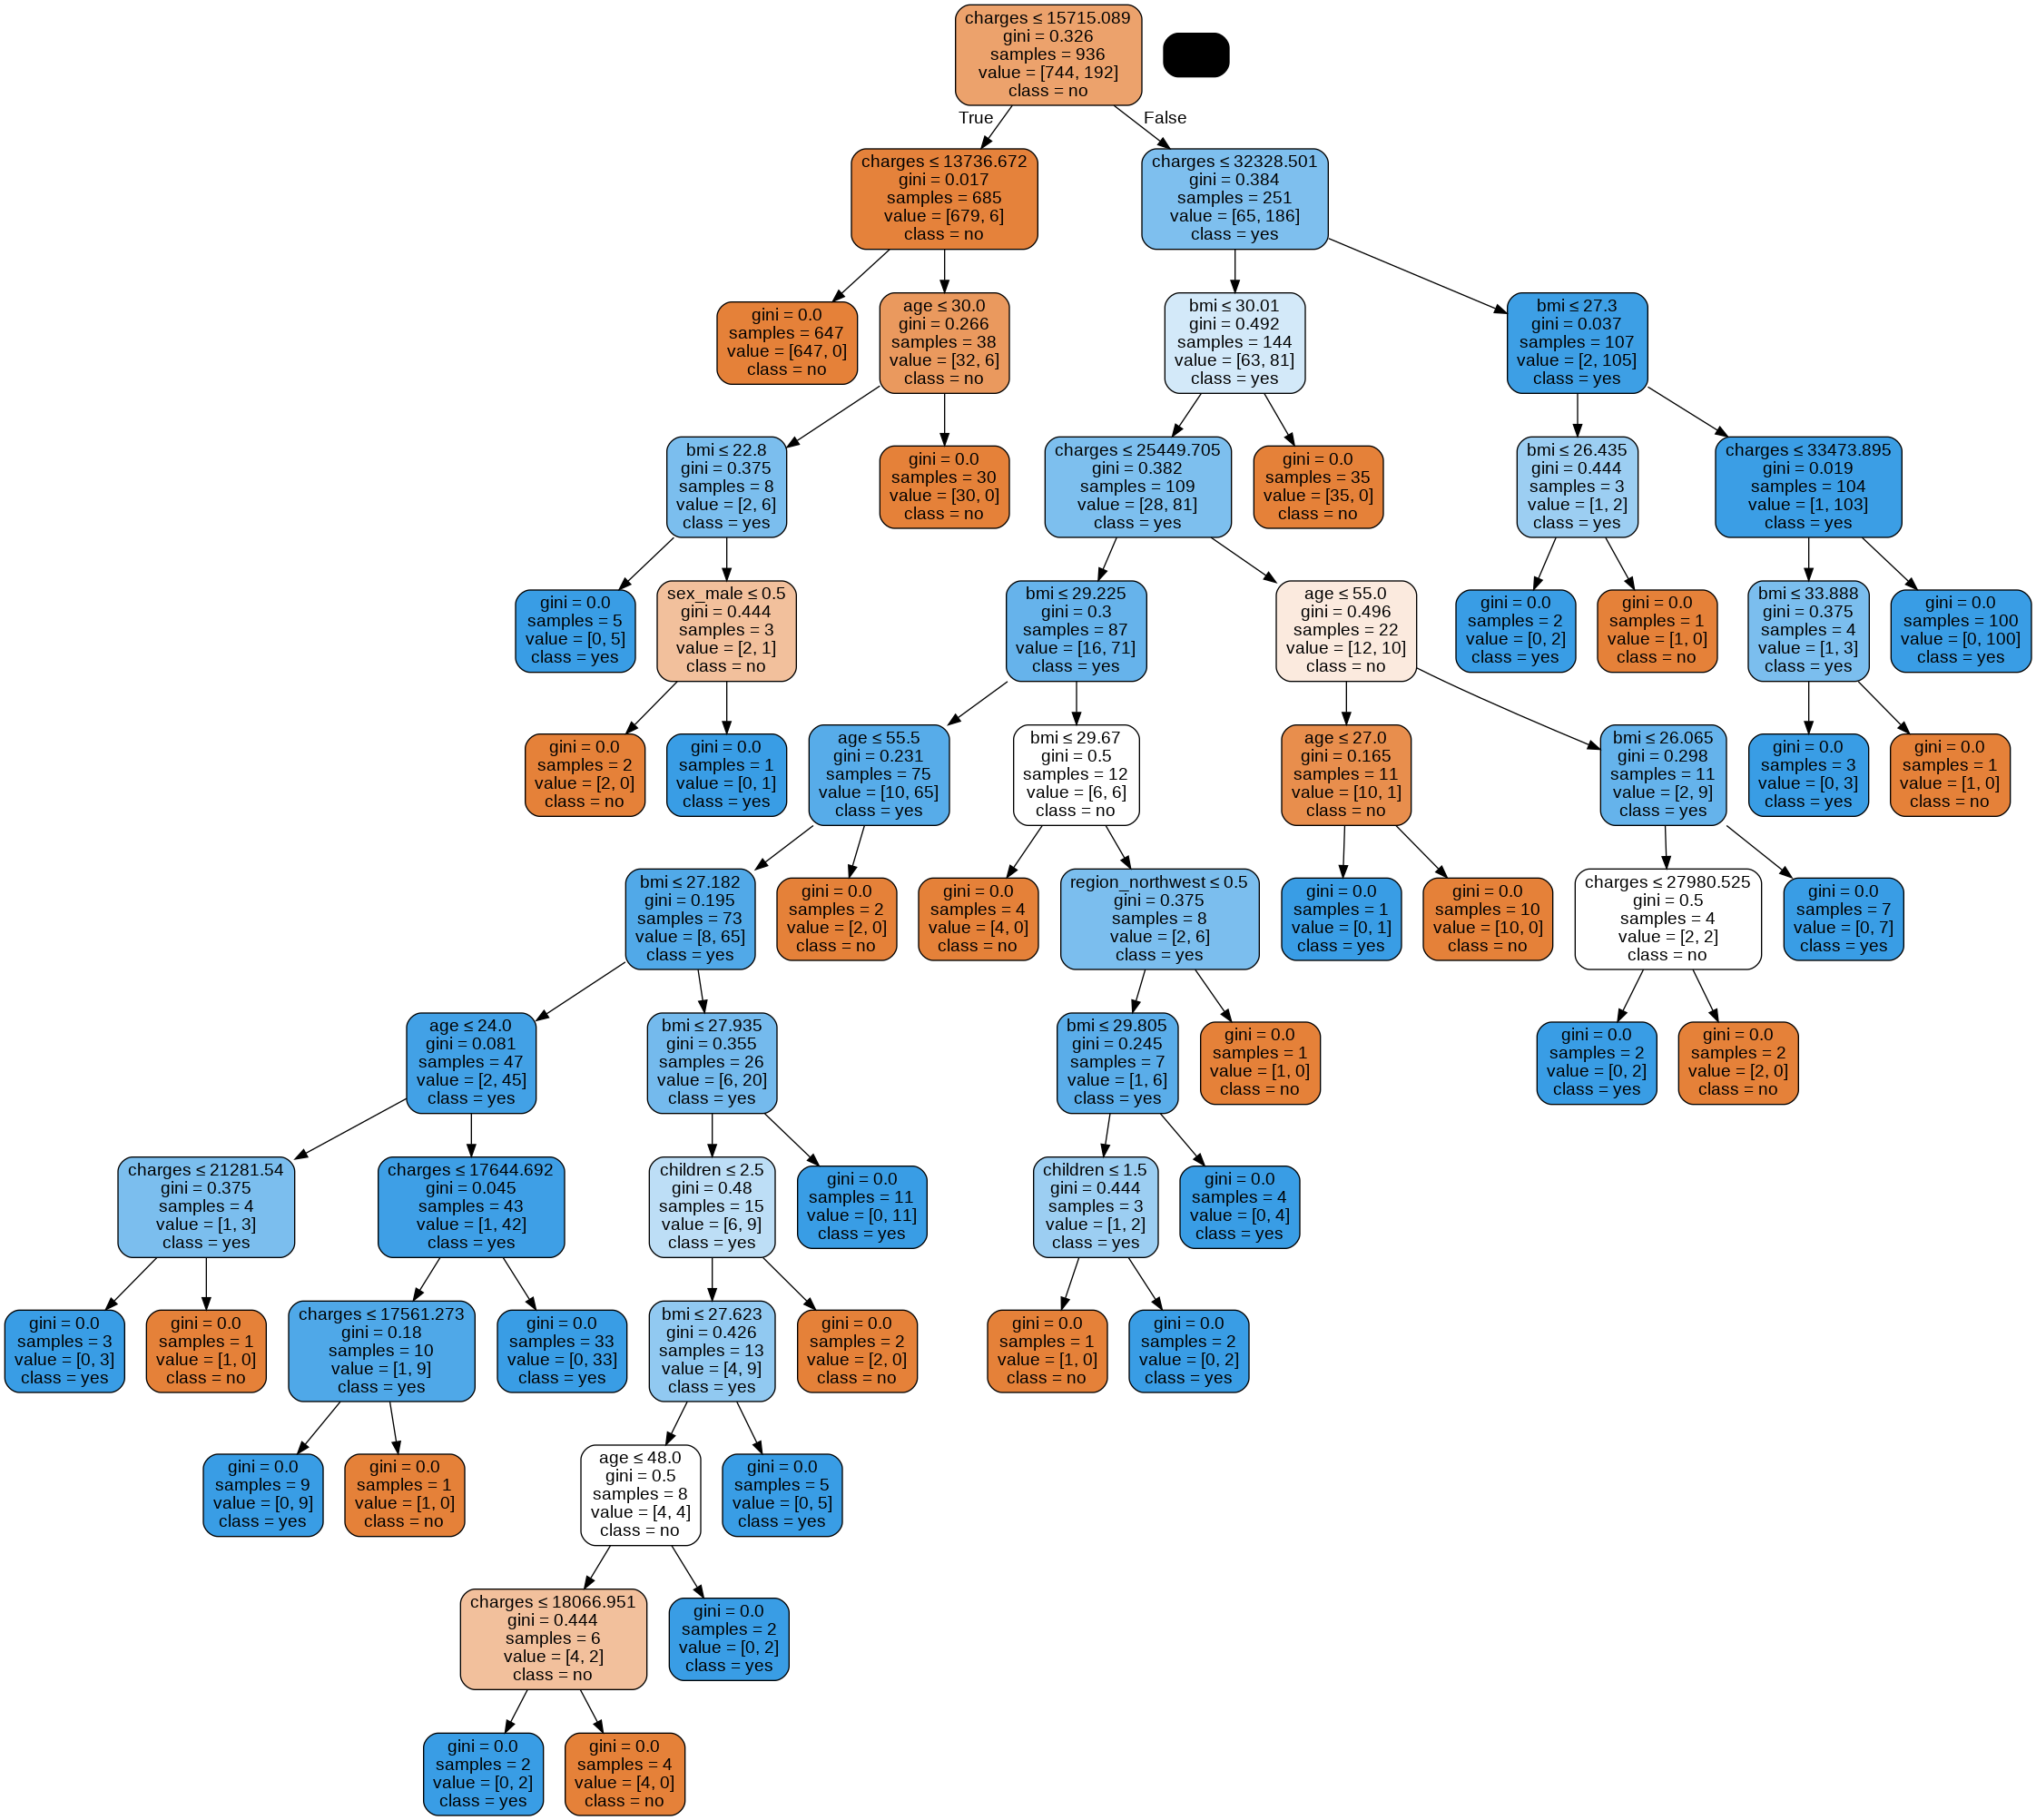

In [ ]:
# Include decision tree visualization here
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus
  
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names = x.columns,class_names=['no', 'yes'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('smoker.png')
Image(graph.create_png())

# Discuss what the model has learned
### Comments below the image ###

The model has model has learned that charges is the best 
feature to start the tree and from there other important features 
include bmi and age.

## 6. (optional 5% extra credit) Implement reduced error pruning to help avoid overfitting.  
- You will need to take a validation set out of your training data to do this, while still having a test set to test your final accuracy. 
- Create a table comparing your decision tree implementation's results on the cars and voting data sets with and without reduced error pruning. 
- This table should compare:
    - a) The # of nodes (including leaf nodes) and tree depth of the final decision trees 
    - b) The generalization (test set) accuracy. (For the unpruned 10-fold CV models, just use their average values in the table).